<a href="https://colab.research.google.com/github/ajinkyabhanudas/SIADS696/blob/dev/Dataset_setup_Ajinkya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook works on the first step of the train pipeline: data loading 
- The idea is to use the contents of this notebook as a makefile target so it can be the first step to run as we keep populating our datastore.








In [134]:
!git clone https://github.com/ajinkyabhanudas/SIADS696.git

Cloning into 'SIADS696'...
remote: Enumerating objects: 411, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 411 (delta 92), reused 96 (delta 45), pack-reused 221
Receiving objects: 100% (411/411), 21.60 MiB | 18.49 MiB/s, done.
Resolving deltas: 100% (216/216), done.


In [303]:
import enum
import glob
import json
import os
import re
from itertools import groupby

from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore')

In [136]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [137]:
try:
  os.chdir('SIADS696')
except:
  print("You're either already in the SIADS696 directory, or the path specified isn't accessible")

### We'll extract our dataset in two parts:
- first extract the overall stats data per channel and store it along with the channel name instead of the id for available channels. (`overall_stats_raw_df`)
- And second, extract the per-video data into another dataframe. (`raw_df`)

In [290]:
rootdir = 'data'
feature_list = ['publishedAt', 'title', 'channelId', 'description',
                'channelTitle', 'tags', 'categoryId', 'viewCount', 
                'likeCount', 'favoriteCount', 'commentCount', 'duration',
                'definition', 'contentRating', 'topicCategories']

ov_dict_list = []
ov_temp_dict = {}

dict_list = []
temp_dict = {}

for path in glob.glob(f'./{rootdir}/*/*'):
  try:
    with open(path, "r") as read_file:
      data = json.load(read_file)
    for channel_id in data.keys():
      ov_temp_dict = data[channel_id]["channel_statistics"]
      channel_name = list(data[channel_id]["video_data"].keys())[0]
      ov_temp_dict["channelName"] = data[channel_id]["video_data"][channel_name]["channelTitle"]
      ov_dict_list.append(ov_temp_dict)
      
      for video_info in data[channel_id]["video_data"].values():
        temp_dict = video_info
        dict_list.append(temp_dict)       
  except:
    pass

overall_stats_raw_df = pd.DataFrame(ov_dict_list)
overall_stats_raw_df.drop("hiddenSubscriberCount", axis=1, inplace=True)

raw_df = pd.DataFrame(dict_list)
raw_df = raw_df[feature_list]

### Next, let's do a quick check on the data and take a quick look at the data in both the dfs

In [291]:
raw_df.info()
raw_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33696 entries, 0 to 33695
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   publishedAt      33696 non-null  object
 1   title            33696 non-null  object
 2   channelId        33677 non-null  object
 3   description      33677 non-null  object
 4   channelTitle     33677 non-null  object
 5   tags             32423 non-null  object
 6   categoryId       33677 non-null  object
 7   viewCount        33648 non-null  object
 8   likeCount        33200 non-null  object
 9   favoriteCount    33676 non-null  object
 10  commentCount     33235 non-null  object
 11  duration         33674 non-null  object
 12  definition       33674 non-null  object
 13  contentRating    33674 non-null  object
 14  topicCategories  33109 non-null  object
dtypes: object(15)
memory usage: 3.9+ MB


,publishedAt,title,channelId,description,channelTitle,tags,categoryId,viewCount,likeCount,favoriteCount,commentCount,duration,definition,contentRating,topicCategories
14818,2014-12-09T19:08:09Z,3 Minute Yoga Flow Vinyasa Handstands Hop-ups ...,UCcox27Gc-NGbb2-X9hdLaMw,3 Minute Yoga Flow Vinyasa Handstands Hop-ups ...,Fightmaster Yoga,"[3 minute yoga, handstands, yoga handstands, y...",26,8894,194,0,13,PT3M23S,hd,{},[https://en.wikipedia.org/wiki/Lifestyle_(soci...
11029,2012-01-24T16:05:18Z,2NE1 years old & my Slutty Frog Dog - vlog #55,UC_ptyMRLOsS1Uj0a34a_xCA,Hooray! I'm an old fart now!\r\n\r\nThank you ...,Chonnyday,"[watch, out, for, that, ghost, lady, in, your,...",22,413643,5517,0,1081,PT3M56S,hd,{},[https://en.wikipedia.org/wiki/Lifestyle_(soci...
14257,2014-07-28T17:00:05Z,Yoga Backbends: Ustrasana with Kino,UCH-81uaxCwAAaSgxRtxMkxg,If you’re looking for yoga videos that will sh...,KinoYoga,"[Kino Yoga, #KinoYoga, Yoga, Ashtanga, Ashtang...",26,39131,486,0,29,PT4M31S,hd,{},[https://en.wikipedia.org/wiki/Lifestyle_(soci...
16210,2021-05-08T19:00:03Z,Can You Escape Being Duct Taped To A Chair?,UC1zZE_kJ8rQHgLTVfobLi_g,"Today Nate, Calli, and Grace are taking three ...",TKOR,"[water bottle flip challenges, water bottle fl...",27,365906,12744,0,1830,PT8M19S,hd,{},"[https://en.wikipedia.org/wiki/Food, https://e..."
8981,2022-07-14T22:39:35Z,How Japanese longbows are made #shorts #inside...,UCHJuQZuzapBh-CuhRYxIZrg,----------------------------------------------...,Insider,[Insider],17,338512,14064,0,105,PT44S,hd,{},"[https://en.wikipedia.org/wiki/Hobby, https://..."


In [292]:
overall_stats_raw_df.info()
overall_stats_raw_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   viewCount        86 non-null     object
 1   subscriberCount  86 non-null     object
 2   videoCount       86 non-null     object
 3   channelName      86 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


,viewCount,subscriberCount,videoCount,channelName
20,179617961,1150000,342,Miss Mina
84,857630029,5720000,1778,Jamie Oliver
31,160377209,1580000,415,SarahBethYoga
40,3340891803,17500000,1961,TED-Ed
83,884896291,4910000,491,How To Cook That


### Let's examine our datatypes and convert them appropriately

In [293]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33696 entries, 0 to 33695
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   publishedAt      33696 non-null  object
 1   title            33696 non-null  object
 2   channelId        33677 non-null  object
 3   description      33677 non-null  object
 4   channelTitle     33677 non-null  object
 5   tags             32423 non-null  object
 6   categoryId       33677 non-null  object
 7   viewCount        33648 non-null  object
 8   likeCount        33200 non-null  object
 9   favoriteCount    33676 non-null  object
 10  commentCount     33235 non-null  object
 11  duration         33674 non-null  object
 12  definition       33674 non-null  object
 13  contentRating    33674 non-null  object
 14  topicCategories  33109 non-null  object
dtypes: object(15)
memory usage: 3.9+ MB


In [294]:
def duration_split(duration):
    try:
      for _, v in groupby(duration, str.isalpha):
        yield ''.join(v)
    except:
      yield np.nan
    
    
def duration_2_secs(duration, duration_split=duration_split):
  temp = 0
  # value = (duration_split(duration))
  for i, val in enumerate(duration_split(duration)):
    
    if i==1 and not val.isalpha():
      temp += float(val)*60
    
    if i==3 and not val.isalpha():
      temp += float(val)

  return(temp)


# duration_2_secs("PT51M12S")

In [295]:
def topic_extract(links_list):
  
  topics_list = []  
  try:
    for link in links_list:
      topics_list.append(link.split("/")[-1].lower())
    
    return(topics_list)
  except:
    pass

In [296]:
def text_prep(val):
  '''the goal is to replace the hypertexts in the 
  in any field to redundant names as vectorizing
  them could be misleading and also leak data'''

  val = str(val).lower()
  process_desc = re.sub(r'http[s]*:.*\w', 'url', val)
  process_desc = re.sub('[^a-zA-Z]', ' ', process_desc)
  process_desc = re.sub(r'\s+', ' ', process_desc)

  process_desc = nltk.sent_tokenize(process_desc)
  if not process_desc:
    process_desc = [nltk.word_tokenize(word) for word in process_desc]
  else:
    process_desc = [nltk.word_tokenize(word) for word in process_desc][0]
    
  
  word_list = [word for word in process_desc if word not in stopwords.words('english')]


  return word_list



In [297]:
text_prep("i if happening")

['happening']

In [298]:
def create_dataset(df, featureset, primary=True):

  if primary:
    df["publishedAt"] = pd.to_datetime(df.publishedAt)
    df['publishedDayNum'] = df.publishedAt.apply(lambda x: x.timetuple().tm_yday)
    df["categoryId"] = df.categoryId.astype(float)
    df["viewCount"] = df.viewCount.astype(float)
    df["likeCount"] = df.likeCount.astype(float)
    df["favoriteCount"] = df.favoriteCount.astype(float)
    df["commentCount"] = df.commentCount.astype(float)
    df['duration_secs'] = df.duration.apply(lambda x: duration_2_secs(x))
    df['topicCategories'] = df.topicCategories.apply(lambda x: topic_extract(x))
    df['tags'] = df.tags.apply(lambda x: topic_extract(x))
    df['channelTitle'] = df.channelTitle.str.lower()
    df['description'] = df.description.apply(lambda x: text_prep(x))
    df['title'] = df.title.apply(lambda x: text_prep(x))
  
  else:
    df['ov_viewCount'] = df.viewCount.astype(float)
    df['ov_subscriberCount'] = df.subscriberCount.astype(float)
    df['ov_videoCount'] = df.videoCount.astype(float)
    df['channelName'] = df.channelName.str.lower()

  return df[featureset]

- It's best to drop tags because, in many cases, the tags tend to contain the channel names, which could as we speculated earlier, lead to data leaks.
- We'll also drop channelId because it is visually unintuitve and we can encode the channelNames with simple Id's if we needed to.
- since we don't have data in the order of millions, we'd abstract out the publishing data to a new variable of `publishedDayNum` that contains the day of the year the video was published.
- on examining `contentRating` values, the dataset in non-null but majorly contains empty dictionaries, which makes it misleading. As a result, we'll drop this feature too.
- on examining `favoriteCount` values, the dataset in non-null but majorly contains a value of `0`, which makes it misleading. As a result, we'll drop it.

- dropped columns list [`tags`, `channelId`, `contentRating`] and [`publishedAt`] after deriving the `publishedDayNum` column from it.

In [304]:
features = ['title', 'description', 'channelTitle',
 'categoryId', 'viewCount', 'likeCount',
 'commentCount', 'duration_secs','definition', 
 'topicCategories', 'publishedDayNum']

preproc1_df = create_dataset(raw_df, features)

In [306]:
preproc1_df.sample(5)

,title,description,channelTitle,categoryId,viewCount,likeCount,commentCount,duration_secs,definition,topicCategories,publishedDayNum
31742,"[made, giant, foot, b, nh]","[mom, gave, birth, handed, b, nh, right, away,...",tasty,26.0,115688.0,4368.0,421.0,842.0,hd,"[food, lifestyle_(sociology)]",266
17752,"[people, laughed, house, went, inside]","[mindwarehouse, incrediblemoments, caughtoncam...",#mind warehouse,24.0,546963.0,6025.0,125.0,1124.0,hd,"[hobby, lifestyle_(sociology)]",69
10162,"[rome, italy, colosseum]","[built, st, c, ad, roman, empire, peaked, colo...",rick steves' europe,19.0,616827.0,3178.0,170.0,102.0,hd,"[lifestyle_(sociology), tourism]",149
16102,"[gang, leaders, hard, time]","[even, regular, frequent, shakedowns, miss, bi...",national geographic,24.0,253071.0,1275.0,145.0,239.0,hd,[entertainment],224
16356,"[skyballs, explode, glitter]","[today, taking, something, wonderful, skyballs...",tkor,27.0,516472.0,12135.0,1423.0,702.0,hd,"[hobby, lifestyle_(sociology)]",54


In [186]:
preproc1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33696 entries, 0 to 33695
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            33696 non-null  object 
 1   description      33696 non-null  object 
 2   channelTitle     33677 non-null  object 
 3   categoryId       33677 non-null  float64
 4   viewCount        33648 non-null  float64
 5   likeCount        33200 non-null  float64
 6   commentCount     33235 non-null  float64
 7   duration_secs    33696 non-null  float64
 8   definition       33674 non-null  object 
 9   topicCategories  33109 non-null  object 
 10  publishedDayNum  33696 non-null  int64  
dtypes: float64(5), int64(1), object(5)
memory usage: 2.8+ MB


Let's again take a look at what percentage of data is missing across all the fields.

In [307]:
missing_data_perc_cols = (preproc1_df.isna().sum()/len(preproc1_df))*100
missing_data_perc_cols

title              0.000000
description        0.000000
channelTitle       0.056387
categoryId         0.056387
viewCount          0.142450
likeCount          1.471985
commentCount       1.368115
duration_secs      0.000000
definition         0.065290
topicCategories    1.742047
publishedDayNum    0.000000
dtype: float64

In [308]:
lost_rows_perc = len(preproc1_df.dropna())/len(preproc1_df)*100
lost_rows_perc

95.58404558404558

It's under 5% in across all cases, which isn't a bad thing at all and we can easily consider dropping the missing fields as we would regularly keep enriching our datastore, which would easily compensate for the missing 5% over time.

In [310]:
preproc2_df = preproc1_df.dropna()

In [311]:
preproc2_df.isna().sum()

title              0
description        0
channelTitle       0
categoryId         0
viewCount          0
likeCount          0
commentCount       0
duration_secs      0
definition         0
topicCategories    0
publishedDayNum    0
dtype: int64

In [312]:
preproc2_df.drop('categoryId', axis=1).describe()

,viewCount,likeCount,commentCount,duration_secs,publishedDayNum
count,3.220800e+04,3.220800e+04,3.220800e+04,32208.000000,32208.000000
mean,3.677086e+06,5.400372e+04,3.259719e+03,688.996802,183.086562
std,5.280129e+07,3.294235e+05,1.394655e+04,696.394964,103.826155
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000
25%,9.927450e+04,1.721000e+03,1.260000e+02,225.000000,93.000000
50%,3.825555e+05,7.664000e+03,5.630000e+02,451.000000,185.000000
75%,1.537845e+06,3.001375e+04,2.144000e+03,830.000000,269.000000
max,5.809870e+09,3.042521e+07,1.124865e+06,3597.000000,366.000000


In [313]:
preproc2_df.drop('categoryId', axis=1).corr()

,viewCount,likeCount,commentCount,duration_secs,publishedDayNum
viewCount,1.000000,0.915600,0.732864,-0.022877,-0.001604
likeCount,0.915600,1.000000,0.863809,-0.023962,0.005050
commentCount,0.732864,0.863809,1.000000,-0.003730,0.001925
duration_secs,-0.022877,-0.023962,-0.003730,1.000000,-0.012563
publishedDayNum,-0.001604,0.005050,0.001925,-0.012563,1.000000


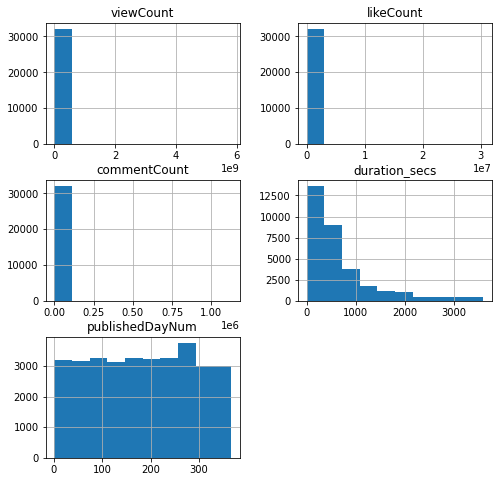

In [314]:
preproc2_df.drop('categoryId', axis=1).hist(figsize=(8,8));

We could consider applying a transformation to the data, to help address the heavy left-skew on most numerical features.

Let's quickly set the same steps up for the `overall_stats_raw_df` df.

In [315]:
overall_stats_raw_df.head()

,viewCount,subscriberCount,videoCount,channelName
0,104555954,886000,81,Historia Civilis
1,38446899,589000,55,Feature History
2,555990509,2020000,447,Overly Sarcastic Productions
3,968644695,4350000,1002,Timeline - World History Documentaries
4,84993307,707000,76,BazBattles


In [316]:
overall_stats_raw_df.dtypes

viewCount          object
subscriberCount    object
videoCount         object
channelName        object
dtype: object

In [317]:
ov_features = ['channelName', 'ov_viewCount', 'ov_subscriberCount', 'ov_videoCount']
ov_stats_pre_df1 = create_dataset(overall_stats_raw_df, ov_features, primary=False)

In [318]:
ov_stats_pre_df1.head()

,channelName,ov_viewCount,ov_subscriberCount,ov_videoCount
0,historia civilis,104555954.0,886000.0,81.0
1,feature history,38446899.0,589000.0,55.0
2,overly sarcastic productions,555990509.0,2020000.0,447.0
3,timeline - world history documentaries,968644695.0,4350000.0,1002.0
4,bazbattles,84993307.0,707000.0,76.0


In [319]:
ov_stats_pre_df1.isna().sum()

channelName           0
ov_viewCount          0
ov_subscriberCount    0
ov_videoCount         0
dtype: int64

With both the datasets ready and a basic relation overview amongst the features, we can now move onto the phase of text processing to make it machine interpretable.

In [320]:
df = pd.merge(preproc2_df, ov_stats_pre_df1, how='left', left_on='channelTitle', right_on='channelName')
df.head()

,title,description,channelTitle,categoryId,viewCount,likeCount,commentCount,duration_secs,definition,topicCategories,publishedDayNum,channelName,ov_viewCount,ov_subscriberCount,ov_videoCount
0,"[congress, vienna, part]","[patreon, url, donate, url, merch, url, mailin...",historia civilis,27.0,800074.0,32071.0,3556.0,3072.0,hd,[knowledge],92,historia civilis,104555954.0,886000.0,81.0
1,"[congress, vienna, part]","[patreon, url, donate, url, merch, url, mailin...",historia civilis,27.0,1413335.0,44184.0,3961.0,2806.0,hd,[knowledge],29,historia civilis,104555954.0,886000.0,81.0
2,[peace],"[patreon, url, donate, url, merch, url, mailin...",historia civilis,27.0,694878.0,38608.0,5421.0,1159.0,hd,"[knowledge, strategy_video_game]",199,historia civilis,104555954.0,886000.0,81.0
3,"[antony, invasion, parthia, b, c, e]","[patreon, url, donate, url, merch, url, mailin...",historia civilis,27.0,1044187.0,35907.0,3369.0,1824.0,hd,"[knowledge, strategy_video_game]",114,historia civilis,104555954.0,886000.0,81.0
4,"[sextus, pompeius, sicilian, war, b, c, e]","[patreon, url, donate, url, merch, url, mailin...",historia civilis,27.0,1290695.0,40590.0,5018.0,2292.0,hd,[knowledge],16,historia civilis,104555954.0,886000.0,81.0


In [321]:
df['std_viewCount'] = df.groupby('channelTitle').viewCount.apply(lambda x: (x - x.mean()) / x.std()).values

In [326]:
unique_topics_list = set()
for topic_list in df.topicCategories.values:
  for topic in topic_list:
    unique_topics_list.add(topic)

unique_titles_word_list = set()
for topic_list in df.title.values:
  for topic in topic_list:
    unique_titles_word_list.add(topic)

In [329]:
# unique_titles_word_list

In [358]:
basic_model_features = ['title', 'topicCategories', 'definition', 'publishedDayNum', 'duration_secs', 'std_viewCount']
basic_model_data = df[basic_model_features]

basic_model_data.head()

,title,topicCategories,definition,publishedDayNum,duration_secs,std_viewCount
0,"[congress, vienna, part]",[knowledge],hd,92,3072.0,-0.587774
1,"[congress, vienna, part]",[knowledge],hd,29,2806.0,0.132511
2,[peace],"[knowledge, strategy_video_game]",hd,199,1159.0,-0.711329
3,"[antony, invasion, parthia, b, c, e]","[knowledge, strategy_video_game]",hd,114,1824.0,-0.301059
4,"[sextus, pompeius, sicilian, war, b, c, e]",[knowledge],hd,16,2292.0,-0.011532


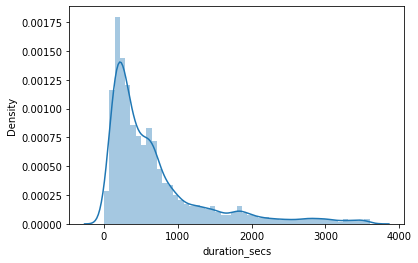

In [599]:
import seaborn as sns
#b4 transform
sns.distplot(basic_model_data.duration_secs+1);

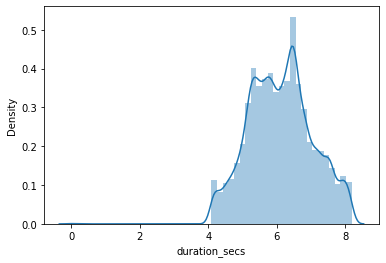

In [600]:
#after transform
sns.distplot(np.log(basic_model_data.duration_secs+1));

In [334]:
word2vec_titles = Word2Vec(basic_model_data.title, min_count=1)
word2vec_topics = Word2Vec(basic_model_data.topicCategories, min_count=1)

In [368]:
# word2vec_titles.wv.vocab
word2vec_titles.wv['artificial'].shape

(100,)

In [339]:
# word2vec_titles.most_similar('travel')

In [364]:
def w2v_models(df, col_list):

  model_dict = {}
  for col in col_list:
    model_dict[col] = Word2Vec(df[col], min_count=1)
  
  return model_dict

In [365]:
w2v_model_dict = w2v_models(basic_model_data, ['title', 'topicCategories'])

In [366]:
w2v_model_dict

{'title': <gensim.models.word2vec.Word2Vec at 0x7f001a951690>,
 'topicCategories': <gensim.models.word2vec.Word2Vec at 0x7f0042190210>}

In [394]:
def vectorise_text(df, model):
  arr = np.zeros(100)
  for word in df:
    arr+=model.wv[word]
    
  return(np.mean(np.expand_dims(arr, axis=1), axis=1))

In [400]:
# vectorise_text(["science", "art"], w2v_model_dict['title'])

In [398]:
basic_model_data['vec_title'] = basic_model_data.title.apply(vectorise_text, model=w2v_model_dict['title'])
basic_model_data['vec_topicCategories'] = basic_model_data.topicCategories.apply(vectorise_text, model=w2v_model_dict['topicCategories'])

In [ ]:
['title', 'topicCategories', 'definition', 'publishedDayNum', 'duration_secs', 'std_viewCount']

In [406]:
titles = pd.DataFrame(basic_model_data.vec_title.tolist(), index= basic_model_data.index, columns=["title_"+str(i) for i in range(1,101)])
topics = pd.DataFrame(basic_model_data.vec_topicCategories.tolist(), index= basic_model_data.index, columns=["topics_"+str(i) for i in range(1,101)])


In [410]:
data_df = pd.concat([titles, topics, basic_model_data[['publishedDayNum', 'duration_secs', 'std_viewCount']], pd.get_dummies(basic_model_data.definition)], axis=1)

In [411]:
data_df.head()

,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,title_10,...,topics_96,topics_97,topics_98,topics_99,topics_100,publishedDayNum,duration_secs,std_viewCount,hd,sd
0,0.921085,-0.776300,0.161458,-1.294525,-0.516865,0.318875,-1.401955,0.658817,-0.592455,-0.534987,...,0.010759,0.162970,-0.095601,-0.170272,-0.138997,92,3072.0,-0.587774,1,0
1,0.921085,-0.776300,0.161458,-1.294525,-0.516865,0.318875,-1.401955,0.658817,-0.592455,-0.534987,...,0.010759,0.162970,-0.095601,-0.170272,-0.138997,29,2806.0,0.132511,1,0
2,0.168113,-0.172816,0.035180,-0.224995,-0.123210,0.064842,-0.249217,0.122814,-0.132376,-0.086653,...,0.052899,0.444102,-0.270265,-0.421385,-0.353525,199,1159.0,-0.711329,1,0
3,1.510565,-1.574027,0.362754,-2.460667,-1.121886,0.678950,-2.622660,1.207679,-1.036503,-0.812885,...,0.052899,0.444102,-0.270265,-0.421385,-0.353525,114,1824.0,-0.301059,1,0
4,1.993987,-1.800736,0.475171,-3.076373,-1.291186,0.770481,-3.276942,1.506734,-1.294124,-1.051870,...,0.010759,0.162970,-0.095601,-0.170272,-0.138997,16,2292.0,-0.011532,1,0


In [545]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [415]:
data_train, data_test = train_test_split(data_df, test_size=0.20, random_state=42)

In [583]:
train_X = data_train.drop("std_viewCount", axis=1)
train_y = data_train.std_viewCount

test_X = data_test.drop("std_viewCount", axis=1)
test_y = data_test.std_viewCount

In [593]:
# train_X

In [595]:
sc = StandardScaler()

train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)


In [596]:
pca = PCA(n_components=20)
pca.fit(train_X)
# print(()))

PCA(n_components=20)

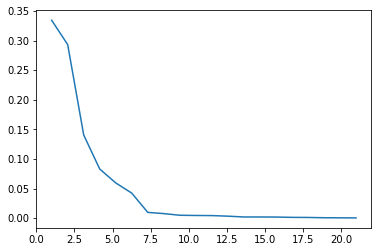

In [597]:
import matplotlib.pyplot as plt
##SCREE PLOT
plt.plot(np.linspace(1,21,20),pca.explained_variance_ratio_);

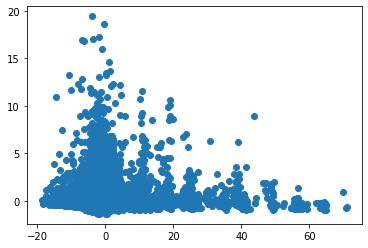

In [591]:
pca = PCA(n_components=1) #components based on the scree plot above

pca_train_X = pca.fit_transform(train_X)

plt.scatter(pca_train_X, train_y);

based on the first PCA, it is clear that the data is not linear and we would have to bear that in mind with the choice of our models

In [590]:
pca_train_X.shape, train_y.shape

((25766, 2), (25766,))

In [566]:
pca = PCA(n_components=5) #components based on the scree plot above

pca_train_X = pca.fit_transform(train_X)
pca_test_X = pca.transform(test_X)


In [567]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [598]:
# train_X=pca_train_X
# test_X=pca_test_X

In [569]:
lr = LinearRegression()
llr = Lasso(alpha=0.1)
rr = Ridge(alpha=1.0)
dr = DummyRegressor(strategy="mean")
svr = SVR(kernel = 'linear')
dtr = DecisionTreeRegressor()

lr.fit(train_X, train_y)
llr.fit(train_X, train_y)
rr.fit(train_X, train_y)
dr.fit(train_X, train_y)
# svr.fit(train_X, train_y)
dtr.fit(train_X, train_y)

DecisionTreeRegressor()

In [578]:
# ret_metrics(train_y, lr.predict(train_X))

In [570]:
# lr.fit(pca_train_X, train_y)
# lr_pred = lr.predict(pca_test_X)

In [571]:
lr.score(train_X, train_y)
# cross_val_score(dtr, train_X, train_y, cv=5)

0.0019887388813636386

In [572]:
lr_pred = lr.predict(test_X)
dr_pred = dr.predict(test_X)
rr_pred = rr.predict(test_X)
# svr_pred = svr.predict(test_X)
dtr_pred = dtr.predict(test_X)
llr_pred = llr.predict(test_X)

In [573]:
def ret_metrics(test_y, pred):

  mae = metrics.mean_absolute_error(test_y, pred)
  mse = metrics.mean_squared_error(test_y, pred)
  rmse = np.sqrt(mse)

  return(mae, mse, rmse)

In [574]:
print(f"LR metrics for mae, mse, rmse are: {ret_metrics(test_y, lr_pred)}")
print(f"LLR metrics for mae, mse, rmse are: {ret_metrics(test_y, llr_pred)}")
print(f"DR metrics for mae, mse, rmse are: {ret_metrics(test_y, dr_pred)}")
print(f"RR metrics for mae, mse, rmse are: {ret_metrics(test_y, rr_pred)}")
# print(f"SVR metrics for mae, mse, rmse are: {ret_metrics(test_y, svr_pred)}")
print(f"DTR metrics for mae, mse, rmse are: {ret_metrics(test_y, dtr_pred)}")


LR metrics for mae, mse, rmse are: (0.5099538079796235, 0.9578134326713134, 0.978679433048081)
LLR metrics for mae, mse, rmse are: (0.5098982274044778, 0.9595058439210536, 0.9795436916856)
DR metrics for mae, mse, rmse are: (0.5099735596756519, 0.9606645347419782, 0.9801349574124872)
RR metrics for mae, mse, rmse are: (0.5099538062076332, 0.9578134342538411, 0.9786794338565826)
DTR metrics for mae, mse, rmse are: (0.6959823537658052, 2.0410250545133404, 1.4286444814975279)


In [575]:
preds_df = pd.DataFrame({"true":test_y, "lr":lr_pred, "dr":dr_pred, "rr":rr_pred, "svr":-1, "dtr":dtr_pred, "llr":llr_pred })

In [576]:
preds_df

,true,lr,dr,rr,svr,dtr,llr
11235,0.350519,-0.022679,-0.000399,-0.022679,-1,0.074861,0.003461
3378,0.518753,-0.005358,-0.000399,-0.005358,-1,-0.079283,-0.010436
28754,-0.235122,0.064690,-0.000399,0.064690,-1,1.013605,0.015094
6899,1.572193,0.005061,-0.000399,0.005061,-1,-0.951188,0.005081
13499,-0.245946,0.027891,-0.000399,0.027891,-1,-0.264621,0.025096
...,...,...,...,...,...,...,...
19677,-0.132264,-0.045837,-0.000399,-0.045837,-1,0.599108,-0.010218
4785,-0.755470,-0.015007,-0.000399,-0.015007,-1,-0.949060,-0.013482
19458,-0.187114,0.002411,-0.000399,0.002411,-1,-0.151529,-0.022517
15381,0.793632,-0.022024,-0.000399,-0.022024,-1,-0.137815,-0.009934
